# Inter Observer Measurements

Import necessary libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy import stats

#### Processing Helper functions

In [2]:
def filter_fixations(data, format):
	"""
	Filter a dataframe of a specified format to return just the relevant data

	format: "gui", "events", or "samples"
	"""
	if format=='gui':
		cols = {"norm_pos_x": "x", "norm_pos_y": "y"}
		filtered= data[data['confidence']>=0.8].rename(columns=cols).query('x>=0 and x<=1 and y>=0 and y<=1')
		fix = filtered[['x', 'y', 'duration']]
	elif format=='events':
		cols= {"mean_gx":"x", "mean_gy":"y"}
		filtered=data[data['type']=="fixation"].rename(columns=cols).query('x>=0 and x<=1 and y>=0 and y<=1')
		fix = filtered[['x', 'y', 'duration']]
	elif format=='samples':
		cols={"gx":"x", "gy":"y"}
		filtered =data[data['type']=="fixation"]
		filtered = filtered[filtered['confidence']>=0.8].rename(columns=cols).query('x>=0 and x<=1 and y>=0 and y<=1')
		fix = filtered[['x', 'y']]

	return fix

In [3]:
clrs= ['blue', 'red']

### Data

#### Load in data

In [4]:
files = pd.read_csv("fixation_files.csv")

In [5]:
autonomous_fixation_list = []
manual_fixation_list = []

In [6]:
for index in range(len(files)):
    file = files.loc[index]
    filename = file["filename"]
    driving = file["drivingType"]
    data = pd.read_csv(filename)
    fix = filter_fixations(data,"gui")
    if driving == "autonomous":
        autonomous_fixation_list.append(fix)
    if driving == "manual":
        manual_fixation_list.append(fix)

#### Making test data
Right now we only have 1 test set of data for both autonomous and manual driving. The code below samples from those distributions to create mock data for testing purposes.

In [7]:
auto_data = pd.read_csv("fixations_autonomous.csv")
man_data = pd.read_csv("fixations_manual.csv")
a = filter_fixations(auto_data, "gui")
m = filter_fixations(man_data, "gui")

In [8]:
n = 10
fixation_list = []
for i in range(n):
    rand = random.uniform(0,1)
    temp = a.sample(frac=rand, replace=True, random_state=i).append(m.sample(frac=1-rand, replace=True, random_state=i))
    fixation_list.append(temp)

## Grid Set up

In [9]:
#determine image size from the video
image_size= (1280,720)

#calculate grid size 
grid_size=(image_size[0]//10, image_size[1]//10)

In [10]:
'''
Converts datatable of fixations at x,y positions to datatable of number of fixations at grid positions 

Parameters: 
    fixations = a table with columns x,y 
Returns:
    table with columns grid_x, grid_y, num
'''
def grid_fixations(fixations):
    fixations['grid_x'] = np.floor(fixations['x']*grid_size[0])
    fixations['grid_y'] = np.floor(fixations['y']*grid_size[1])
    fixations = fixations.groupby(['grid_x', 'grid_y']).size().reset_index(level=['grid_x', 'grid_y'], name='num')
    
    blank_data = []
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            blank_data.append([x,y,0])
    blank = pd.DataFrame(blank_data, columns = ['grid_x', 'grid_y','num']) 
    
    fixations = fixations.append(blank, ignore_index=True)
    return fixations.groupby(['grid_x', 'grid_y']).sum().reset_index(level=['grid_x', 'grid_y'])

In [11]:
def grid_all_subjects(fixation_list):
    #create grid table 
    grid_positions = []
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            grid_positions.append([x,y])
    all_gridded_fixations = pd.DataFrame(grid_positions, columns = ['x', 'y']) 

    #fill in table with column for each subject
    for i in range(len(fixation_list)): 
        gridded_fixations = grid_fixations(fixation_list[i])
        col_name = 'subject' + str(i)
        all_gridded_fixations[col_name] = gridded_fixations['num']

    #add total column with the total number of fixations at that grid position
    col_list = list(all_gridded_fixations)
    col_list.remove('x')
    col_list.remove('y')
    all_gridded_fixations['total'] = all_gridded_fixations[col_list].sum(axis=1)
    
    return all_gridded_fixations

For now, use ```gridded_data``` and ```fixation_list``` below. Once we have actual data, replace with the versions for autonomous and manual respectively. 

In [12]:
gridded_data = grid_all_subjects(fixation_list)
# gridded_autonomous = grid_all_subjects(autonomous_fixation_list)
# gridded_manual = grid_all_subjects(manual_fixation_list)

# Inter Observer Congruency (IOC) Measurement

Idea: Build a saliency map from all observers except the ith observer. To calculate degree of similarity between ith observer and others, calculate hit rate. Iterate over all subjects and average scores to get the IOC. 

1. Iterate over all fixation positions(x,y)
2. Convert fixation positions to gridded positions
3. For each grid position, map position to number of fixations in that grid position
4. Adaptive Binarization - yes or no whether some threshold number t or more fixations in that position 


In [13]:
'''
Parameters: 
    n = number of subjects
    table = 
''' 
def ioc(n, table, thresholds):
    rates= pd.DataFrame([])
    for i in range(n):
        for t in thresholds: 
            temp = pd.DataFrame([], columns={'subject', 'others_sum','binarized'})
            col_name = 'subject' + str(i)
            temp['subject'] = table[col_name]
            temp['others_sum'] = table['total'] - table[col_name]
            temp['binarized'] = temp['others_sum'] > t
            rate = sum(temp[temp['binarized']]['subject'])/sum(temp['subject'])
            rates = rates.append([[col_name, rate, t]], ignore_index=True)
        
    ioc_rates= rates.rename(columns={0: "subject", 1: "hit_rate", 2:"threshold"})
    return ioc_rates

Need to determine what thresholds to use

In [14]:
thresholds = [5, 10, 15, 20]

The chart below shows the hit rate for each subject at each of the thresholds defined above. This will be useful in determining what threshold to use later.

In [15]:
ioc(len(fixation_list), gridded_data, thresholds)

,subject,hit_rate,threshold
0,subject0,0.729294,5
1,subject0,0.557532,10
2,subject0,0.412451,15
3,subject0,0.300723,20
4,subject1,0.850213,5
5,subject1,0.692964,10
6,subject1,0.590618,15
7,subject1,0.500000,20
8,subject2,0.862643,5
9,subject2,0.733611,10


# Pairwise Comparison
To measure how much of a subject's fixations match with all other subjects'

1. Convert fixations to their locations in a grid
2. Since all the subjects have the same grid, the vectors being compared for each subject now all have the same length since each subject has one entry per grid position that contains the number of fixations at that position 
3. Calculate correlation between each subject 
4. Convert correlations to z-scores with Fisher Z-Transformation
5. Average z-scores 
6. Convert to probabilities

Note on Fisher Z-Transformation:

The Fisher Z-Transformation is a way to transform the sampling distribution of Pearson’s r (i.e. the correlation coefficient) so that it becomes normally distributed. The “z” in Fisher Z stands for a z-score.
The formula to transform r to a z-score is:
z’ = .5[ln(1+r) – ln(1-r)]

[Reference](statisticshowto.com/fisher-z/)

In [16]:
def fisher(r):
    return 0.5 * (np.log(1+r) - np.log(1-r))

In [17]:
def pairwise(n, table):
    scores = pd.DataFrame([])
    for i in range(n):
        col_name = 'subject' + str(i)
        z_scores = []
        for other in range(n):
            if i != other: 
                other_name = 'subject' + str(other)
                corr = np.corrcoef(table[col_name], table[other_name])[0][1]
                z= fisher(corr)
                z_scores.append(z)
        avg_z = np.mean(z_scores)
        scores = scores.append([["subject" + str(i), avg_z,stats.norm.cdf(avg_z)]])
    return scores.rename(columns={0:"observer", 1:"average z score", 2:"probability"})

Run

In [18]:
results = pairwise(len(fixation_list), gridded_data)

In [19]:
results

,observer,average z score,probability
0,subject0,0.395544,0.653779
0,subject1,1.003876,0.842281
0,subject2,1.152909,0.875526
0,subject3,1.142159,0.873306
0,subject4,1.112476,0.867033
0,subject5,1.131651,0.871109
0,subject6,1.013951,0.844697
0,subject7,1.147571,0.874427
0,subject8,0.677230,0.750870
0,subject9,1.111847,0.866898


# Visualization of Correlations
Another approach that visualizes correlations between subjects

[reference source](https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3)


In [20]:
def visualize_corr(grid_table):
    data = grid_table.drop(["x", "y","total"], axis=1)
    correlations = data.corr()
    correlations
    corr_plot(correlations, data)
    return correlations

In [21]:
def corr_plot(correlations, data):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations,cmap='coolwarm', vmin=0, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(data.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(data.columns)
    ax.set_yticklabels(data.columns)
    plt.show()

Run

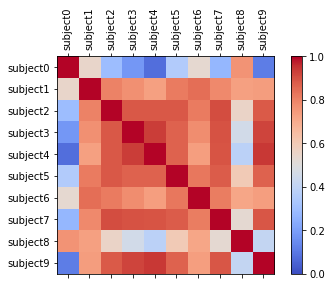

In [22]:
correlations = visualize_corr(gridded_data)

In [23]:
correlations

,subject0,subject1,subject2,subject3,subject4,subject5,subject6,subject7,subject8,subject9
subject0,1.000000,0.547587,0.298892,0.181050,0.080654,0.357703,0.531962,0.275513,0.764874,0.114461
subject1,0.547587,1.000000,0.804516,0.772135,0.730807,0.820278,0.844538,0.788324,0.733777,0.741727
subject2,0.298892,0.804516,1.000000,0.890592,0.888994,0.889015,0.818310,0.908948,0.558071,0.884124
subject3,0.181050,0.772135,0.890592,1.000000,0.933643,0.869120,0.778943,0.899799,0.460425,0.924445
subject4,0.080654,0.730807,0.888994,0.933643,1.000000,0.869211,0.735151,0.895028,0.383784,0.944372
subject5,0.357703,0.820278,0.889015,0.869120,0.869211,1.000000,0.825779,0.880471,0.598704,0.869910
subject6,0.531962,0.844538,0.818310,0.778943,0.735151,0.825779,1.000000,0.815100,0.717141,0.736686
subject7,0.275513,0.788324,0.908948,0.899799,0.895028,0.880471,0.815100,1.000000,0.527368,0.892217
subject8,0.764874,0.733777,0.558071,0.460425,0.383784,0.598704,0.717141,0.527368,1.000000,0.412510
subject9,0.114461,0.741727,0.884124,0.924445,0.944372,0.869910,0.736686,0.892217,0.412510,1.000000
